# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning
Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import sys
sys.path.append('./src')
import pandas as pd
import random

# from tqdm.notebook import tqdm


In [2]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Seed setting for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)


In [4]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:95%]', 'train[95%:]'],
    # shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    with_info=True
)


2025-07-21 17:32:52.272540: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-07-21 17:32:52.272567: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-07-21 17:32:52.272571: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-07-21 17:32:52.272605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-21 17:32:52.272627: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


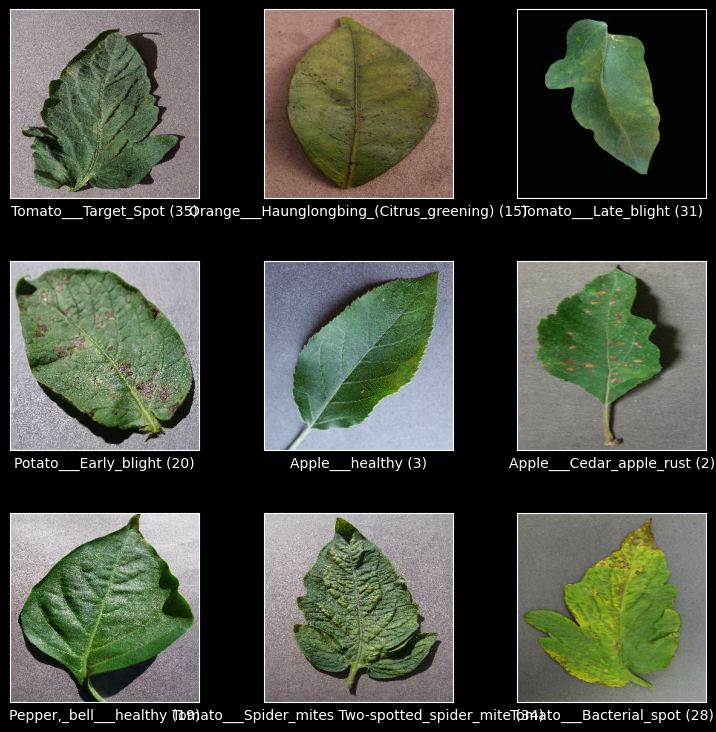

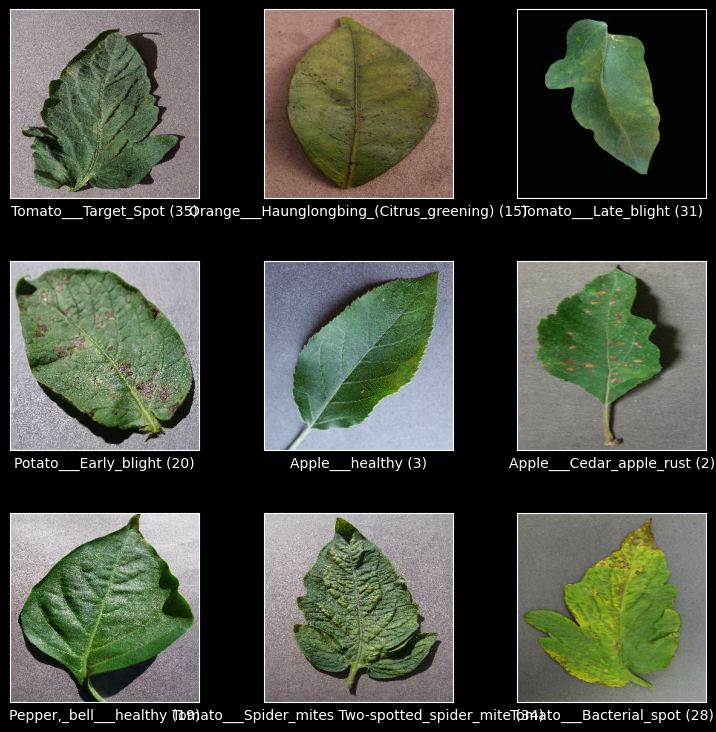

In [5]:
# Show example from the dataset
tfds.show_examples(ds_train, ds_info)


In [6]:
# ds_info


In [7]:
# Extract only labels (not images) for counting
labels_list = []
for _, label in ds_train:
    labels_list.append(label.numpy())

# Convert to pandas Series for fast operations
labels_series = pd.Series(labels_list)

number_of_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {number_of_classes}")
class_names = ds_info.features['label'].names

# Count using pandas (fast) but memory-efficient
class_counts = labels_series.value_counts().sort_index()

# Print the counts with class names
print("Number of images per class:")
for idx, count in class_counts.items():
    print(f"{class_names[idx]}: {count} images")


KeyboardInterrupt: 

In [ ]:
# Visualize the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in PlantVillage Dataset')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import config_par as cfp # setup constants
NUM_CLASSES         = ds_info.features['label'].num_classes
ARCH_CHOICE         = 1


In [ ]:
# Preprocess and batch the datasets
from preprocessing import preprocess

train_ds = ds_train.map(lambda image, label: preprocess(image, label, ds_info, cfp.IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(cfp.BATCH_SIZE[ARCH_CHOICE]).prefetch(tf.data.AUTOTUNE)
val_ds   = ds_val.map  (lambda image, label: preprocess(image, label, ds_info, cfp.IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(cfp.BATCH_SIZE[ARCH_CHOICE]).prefetch(tf.data.AUTOTUNE)
test_ds  = ds_test.map (lambda image, label: preprocess(image, label, ds_info, cfp.IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(cfp.BATCH_SIZE[ARCH_CHOICE]).prefetch(tf.data.AUTOTUNE)


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Activation, BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, Rescaling, Add 
from keras.optimizers.legacy import Adam, SGD
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [ ]:
def simple_cnn_v0(#input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                   num_classes=NUM_CLASSES,
                   drop_rate=cfp.DROP_RATE[0],
                #    l2_reg=cfp.L2_REGULARIZATION[0],
                   ):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        Dropout(drop_rate),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
def simple_cnn_v1(#input_shape=(cfp.IMG_SIZE[0], cfp.IMG_SIZE[1], 3),
                   num_classes=NUM_CLASSES,
                   drop_rate=cfp.DROP_RATE[1],
                   l2_reg=cfp.L2_REGULARIZATION[1]):
    model = Sequential([

        Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Dropout(drop_rate),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Dropout(drop_rate),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(num_classes, activation='softmax')
        
    ])
    return model


In [ ]:
def simple_cnn_v2(#input_shape=(cfp.IMG_SIZE[0], cfp.IMG_SIZE[1], 3),
                num_classes=NUM_CLASSES,
                drop_rate=cfp.DROP_RATE[2],
                l2_reg=cfp.L2_REGULARIZATION[2]):
    model = Sequential([

        Conv2D(16, (5, 5), padding='same', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Conv2D(32, (5, 5), padding='same', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Conv2D(64, (5, 5), padding='same', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        # Flatten(),
        GlobalAveragePooling2D(),

        Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(drop_rate),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
def simple_cnn_v3(#input_shape=(cfp.IMG_SIZE[0], cfp.IMG_SIZE[1], 3),
                num_classes=NUM_CLASSES,
                drop_rate=cfp.DROP_RATE[3],
                l2_regularization=cfp.L2_REGULARIZATION[3]):
    model = Sequential([

        Conv2D(16, (5, 5), padding='same', kernel_regularizer=l2(l2_regularization)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Conv2D(32, (5, 5), padding='same', kernel_regularizer=l2(l2_regularization)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Conv2D(64, (5, 5), padding='same', kernel_regularizer=l2(l2_regularization)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(l2_regularization)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        # Flatten(),
        GlobalAveragePooling2D(),

        Dense(64, activation='relu', kernel_regularizer=l2(l2_regularization)),
        Dropout(drop_rate),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
def simple_resnet(input_shape=(cfp.IMG_SIZE[0], cfp.IMG_SIZE[1], 3), 
                  num_classes=NUM_CLASSES,
                  drop_rate=cfp.DROP_RATE[4],
                  l2_reg=cfp.L2_REGULARIZATION[4]):
    inputs = Input(shape=input_shape)
    
    # First block
    shortcut_1 = Conv2D(16, (1, 1), strides=2, padding='same')(inputs)  # Match shape
    x = Conv2D(16, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(drop_rate)(x)
    x = Add()([x, shortcut_1])  # Skip connection

    # Second block with skip connection
    shortcut_2 = Conv2D(32, (1, 1), strides=2, padding='same')(x)  # Match shape
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(drop_rate)(x)
    x = Add()([x, shortcut_2])  # Skip connection
    
    # Third block
    shortcut_3 = Conv2D(64, (1, 1), strides=2, padding='same')(x)  # Match shape
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(drop_rate)(x)
    x = Add()([x, shortcut_3])  # Skip connection

    # Global pooling and output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(drop_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model


In [ ]:
models_list = [simple_cnn_v0, simple_cnn_v1, simple_cnn_v2, simple_cnn_v3, simple_resnet]
if ARCH_CHOICE not in range(0, len(models_list) + 1):
    raise ValueError("Invalid architecture choice")
else:
    model = models_list[ARCH_CHOICE]()

model.build(input_shape=(None, cfp.IMG_SIZE[0], cfp.IMG_SIZE[1], 3))  # Build the model with dynamic batch size
model.summary()


In [ ]:
optimizer = Adam(learning_rate=0.0002)
# optimizer = SGD(learning_rate=0.05, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

check_point_filename = f'./weights/best_model_v{ARCH_CHOICE}.h5'  # Checkpoint filename for different architectures


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get all labels from the training set
labels = []
for _, label in ds_train:
    labels.append(label.numpy())
labels = np.array(labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict


In [ ]:
import pickle

TRAIN = True  # Change to False to only visualize an already trained model's history

if TRAIN:
    # Train the model
    print(f"Training the model v{ARCH_CHOICE}...")
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=cfp.N_EPOCHS[ARCH_CHOICE],
    callbacks=[
        EarlyStopping(monitor='val_loss',
                      patience=cfp.EARLY_PATIENCE[ARCH_CHOICE],
                      restore_best_weights=True,
                      verbose=1),
        ModelCheckpoint(check_point_filename,
                        monitor='val_loss',
                        save_best_only=True,
                        verbose=1),
        ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1,
                          patience=cfp.REDUCE_LR_PATIENCE[ARCH_CHOICE],
                          verbose=1)
    ],
    class_weight=class_weights_dict,
    )
    # Save history after training
    with open(f'./train-hist/history_v{ARCH_CHOICE}.pkl', 'wb') as f:
        pickle.dump(history.history, f)
else:
    # Load history if not training
    with open(f'./train-hist/history_v{ARCH_CHOICE}.pkl', 'rb') as f:
        loaded_history = pickle.load(f)


In [ ]:
# Dummy class to mimic Keras History for plotting
class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict


In [ ]:
from plotting import plot_model_history
if not TRAIN:
    history = DummyHistory(loaded_history)
else:
    pass
plot_model_history(history)
plt.savefig(f'./train-hist/history_v{ARCH_CHOICE}.png', dpi=400, bbox_inches='tight')
